In [1]:
using Revise
using Bilevel

using ForwardDiff
using DiffResults
using RigidBodyDynamics
using MeshCat
using MeshCatMechanisms
using Base.Threads
using Plots
using Interpolations
using StaticArrays

using Bilevel: VariableSelector, ConstraintSelector, add_var!, add_ineq!

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007fa0931765eb, Ptr{Nothing} @0x00007fa093147204, P

In [ ]:
nthreads()

# Synthesizing a controller

In [ ]:
urdf = joinpath("..", "urdf", "panda", "panda_arm.urdf")
mechanism = parse_urdf(Float64, urdf)
obstacles = []
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [ ]:
Δt = 0.05
N = 50

q0 = [0., .3, 0., -2.75, 0., -1.65, 0.]
qN = [0., .8, 0., -1.67, 0., -2.2, 0.]

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, num_positions(mechanism), x -> vs(x, :q1) - q0)
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    
    add_eq!(sim_data, :cqN, num_positions(mechanism), x -> vs(x, Symbol("q", N)) - qN)
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))
    
#     add_ineq!(sim_data, :cN2, 1, x -> -pi - vs(x, Symbol("q", Int(N/2)))[4])
end

function add_prob_obj!(sim_data)
    for n = 1:N
        add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("v", n))'*sim_data.vs(x, Symbol("v", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # torques limits
    u_limit = 1000.
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)

    # step size limit
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= q0
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

In [ ]:
sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data)
traj = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1)

In [ ]:
setanimation!(mvis, traj[7], traj[1])

In [ ]:
# package the resulting controller in a ctrl function to test
function feedforward_ctrl!(u,t,x)
    i = min(max(searchsortedfirst(traj[7], t),1),length(traj[7]))
    u_nom = traj[3][i]
    u .= u_nom
end

function feedback_ctrl!(u,t,x)
    if t >= traj[7][end]
        u .= 0.
        return
    end
    
    i = min(max(searchsortedfirst(traj[7], t),1),length(traj[7]))

    Kp = 0.
    Kd = 0.
    
    q = configuration(x)
    v = velocity(x)
        
    q_nom = traj[1][i]
    v_nom = traj[2][i]
    u_nom = traj[3][i]
    
    u .= u_nom + Kp*(q - q_nom) + Kd*(v - v_nom)
end

x0 = MechanismState(mechanism)
set_configuration!(x0,traj[1][1])
set_velocity!(x0,traj[2][1])
setdirty!(x0)

sim_data = get_sim_data_indirect(mechanism,env,Δt)

# traj_sim = Bilevel.simulate(sim_data,feedforward_ctrl!,x0,N)
traj_sim = Bilevel.simulate(sim_data,feedback_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, traj_sim[6], traj_sim[1])

# Generating data with controller

In [ ]:
Δt = 0.02
N = 100

μ_floor = .1
μ_box = .05

urdf = joinpath("..", "urdf", "panda", "panda_arm_box.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, μ_floor)

box = findbody(mechanism, "box")
point = Point3D(default_frame(box), SVector([-.25,0.,.25]...))
normal = FreeVector3D(default_frame(box), SVector([-1.,0.,0.]...))
box_obs = Obstacle(box, point, normal, :xyz, μ_box)

obstacles = [floor_obs, box_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [ ]:
# same feedback but ignoring the box state
function feedback_ctrl!(u,t,x)
    Kp = 5.
    Kd = 1.
    
    q = configuration(x)[8:end]
    v = velocity(x)[7:end]
    i = min(max(1,searchsortedfirst(traj[7], t)),length(traj[3]))
    
    q_nom = traj[1][i+1]
    v_nom = traj[2][i+1]
    u_nom = traj[3][i]
    u[7:end] .= u_nom + Kd*(v - v_nom) + Kp*(q - q_nom)
end

In [ ]:
x0 = MechanismState(mechanism)
set_configuration!(x0,vcat([1.,0.,0.,0.,.8,0.,.275],traj[1][1]))
set_velocity!(x0,vcat([0.,0.,0.,0.,0.,0.],traj[2][1]))
setdirty!(x0)

sim_data = get_sim_data_indirect(mechanism,env,Δt)

traj_sim = Bilevel.simulate(sim_data,feedback_ctrl!,x0,N+10)

In [ ]:
setanimation!(mvis, traj_sim[6], traj_sim[1])

# Generating simpler data with just the cube initial velocity

In [186]:
μ_floor = 10.

# urdf = joinpath("..", "urdf", "box.urdf")
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, μ_floor)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [187]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8702
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8702`, ProcessExited(0))

Created new window in existing browser session.


Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [207]:
Δt = 0.01
N = 50

x0 = MechanismState(mechanism)
set_configuration!(x0,[1.,0.,0.,0.,0.,0.,0.])
set_velocity!(x0,[0.,0.,0.,10.,0.,0.])
setdirty!(x0)

sim_data = get_sim_data_indirect(mechanism,env,Δt)
# sim_data = get_sim_data_direct(mechanism,env,Δt)

null_ctrl! = (u,t,x) -> u[:] .= 0.
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, -1.17874e-13, 4.16423e-14, 0.09019, -3.92428e-15, 0.0], [1.0, 0.0, -0.000474572, 4.16423e-14, 0.170662, -3.92428e-15, 0.0], [0.999998, 0.0, -0.0014156, 4.16423e-14, 0.241505, -3.92428e-15, 0.0], [0.999995, 0.0, -0.00281568, 4.16423e-14, 0.302805, -3.92428e-15, 0.0], [0.999986, 0.0, -0.00466776, 4.16423e-14, 0.354645, -3.92428e-15, 0.0], [0.99997, 0.0, -0.00696482, 4.16423e-14, 0.397106, -3.92428e-15, 0.0], [0.999944, 0.0, -0.00961267, 4.16423e-14, 0.430248, -3.92428e-15, 0.0], [0.999911, 0.0, -0.0123242, 4.16423e-14, 0.454084, -3.92428e-15, 8.86768e-8], [0.99987, 0.0, -0.015039, 4.16423e-14, 0.468615, -3.92428e-15, 1.0338e-7]  …  [0.994875, 9.33789e-14, -0.0997864, 3.26327e-14, 0.473844, 1.14101e-26, 0.0], [0.994594, 9.33789e-14, -0.102511, 3.26327e-14, 0.473844, 1.14101e-26, 0.0], [0.994306, 9.33789e-14, -0.105235, 3.26327e-14, 0.473844, 1.14101e-26, 0.0], [0.99401, 9.33789e-14, -0.107957, 3.26327e-14, 0.473844, 1.14101

In [208]:
setanimation!(mvis, traj_sim[6], traj_sim[1])

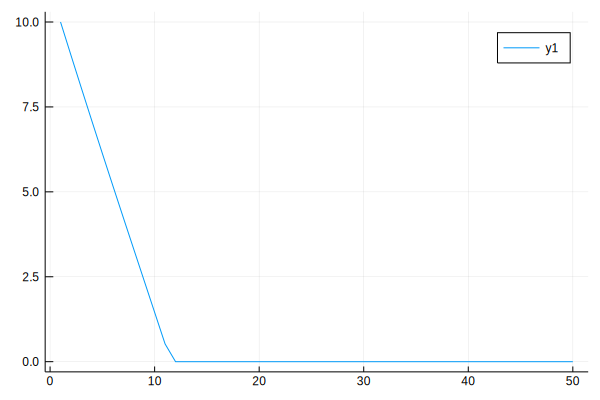

In [209]:
plot(traj_sim[7][11,:])

In [130]:
traj_sim[4]

100-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                         
 [0.999995, 0.0, 0.0, 0.499998, 0.0, 0.95095]           
 [0.99999, 0.0, 0.0, 0.499995, 0.0, 0.901901]           
 [0.999995, 0.0, 0.0, 0.499997, 0.0, 0.852851]          
 [0.999995, 0.0, 0.0, 0.499997, 0.0, 0.803801]          
 [0.999995, 0.0, 0.0, 0.499997, 0.0, 0.754752]          
 [0.999994, 0.0, 0.0, 0.499997, 0.0, 0.705702]          
 [0.999994, 0.0, 0.0, 0.499997, 0.0, 0.656652]          
 [0.999994, 0.0, 0.0, 0.499997, 0.0, 0.607602]          
 [0.999994, 0.0, 0.0, 0.499997, 0.0, 0.558553]          
 [0.999994, 0.0, 0.0, 0.499997, 0.0, 0.509503]          
 [0.999994, 0.0, 0.0, 0.499997, 0.0, 0.460453]          
 [0.999994, 0.0, 0.0, 0.499997, 1.29247e-26, 0.411404]  
 ⋮                                                      
 [0.999525, 0.0968713, 0.0, 0.0968713, 0.0, -1.0159e-17]
 [1.00047, 0.0968713, 0.0, 0.0968713, 0.0, -1.0159e-17] 
 [1.00047, 0.0968713, 0.0, 0.0968713, 0.0, -1.015

# Estimating the parameters

## Bilevel

In [222]:
function get_estimation_data_direct(mechanism::Mechanism,env::Environment)
    vs = VariableSelector()

    add_var!(vs, :q0, num_positions(mechanism))
    add_var!(vs, :v0, num_velocities(mechanism))
    add_var!(vs, :u0, num_velocities(mechanism))
    add_var!(vs, :qnext, num_positions(mechanism))
    add_var!(vs, :vnext, num_velocities(mechanism))
    add_var!(vs, :h, 1)
    
    cs = ConstraintSelector()
    
    add_ineq!(cs, :μ_pos, 1)

    state_cache = [StateCache(mechanism) for n = 1:2]
    envj_cache = [EnvironmentJacobianCache(env) for n = 1:2]

    generate_solver_fn = :generate_solver_fn_estimation_direct
    extract_sol = :nothing

    n_options = Dict{String, Any}()
    n_options["num_fosteps"] = 2
    n_options["num_sosteps"] = 25
    n_options["c"] = 1.
    n_options["c_fos"] = 1.
    n_options["c_sos"] = 1.
    n_options["ls_method"] = :svd

    f_options = Dict{String, Any}()
    f_options["num_fosteps"] = 1
    f_options["num_sosteps"] = 15
    f_options["c"] = 1.
    f_options["c_fos"] = 1.
    f_options["c_sos"] = 1.
    f_options["ls_method"] = :svd
    
    n_vs = VariableSelector()
    for i = 1:length(env.contacts)
        add_var!(n_vs, Symbol("c_n", i), 1)
    end

    n_cs = ConstraintSelector()
    for i = 1:length(env.contacts)
        add_ineq!(n_cs, Symbol("c_n_pos", i), 1)
        add_ineq!(n_cs, Symbol("ϕ", i), 1)
    end

    f_vs = VariableSelector()
    for i = 1:length(env.contacts)
        β_dim = size(env.contacts[i].obstacle.basis,2)
        add_var!(f_vs, Symbol("β", i), β_dim)
    end

    f_cs = ConstraintSelector()
    for i = 1:length(env.contacts)
        β_dim = size(env.contacts[i].obstacle.basis,2)
        add_ineq!(f_cs, Symbol("β_pos", i), β_dim)
        add_ineq!(f_cs, Symbol("fric_cone", i), 1)
    end

    sim_data = SimData(mechanism,env,
                       state_cache,envj_cache,
                       0.,vs,cs,generate_solver_fn,extract_sol,
                       [],[],[],
                       [n_vs],[n_cs],[n_options],
                       [f_vs],[f_cs],[f_options],
                       0,[],[])

    sim_data
end

get_estimation_data_direct (generic function with 1 method)

In [210]:
function load_data(traj, sim_data)
    vs = sim_data.vs
    data = []
    
    for n = 1:10
        q0 = traj_sim[1][n]
        v0 = traj_sim[2][n]
        u0 = zeros(num_velocities(mechanism)) #traj_sim[3][n]
        h = traj_sim[6][n+1] - traj_sim[6][n]
        qnext = traj_sim[1][n+1]
        vnext = traj_sim[2][n+1]
        
        sample = zeros(vs.num_vars)
        sample[vs(:q0)] = q0
        sample[vs(:v0)] = v0
        sample[vs(:u0)] = u0
        sample[vs(:qnext)] = qnext
        sample[vs(:vnext)] = vnext
        sample[vs(:h)] = [h]
        
        push!(data, sample)
    end
    
    data
end

load_data (generic function with 1 method)

In [223]:
function generate_solver_fn_estimation_direct(sim_data, data)
    vs = sim_data.vs
    cs = sim_data.cs
    num_samples = length(data)
    num_vel = num_velocities(mechanism)
    
    function eval_obj(params::AbstractArray{T}) where T
        # set the friction coefficient for the floor
        obstacles[1].μ = params[1]
        
        # evaluate the dynamics residual on each datapoint as an inner problem
        losses = Array{T,1}(undef, num_samples)
        for i = 1:num_samples # PARRALEL
            sample = data[i]
            q0 = vs(sample, :q0)
            v0 = vs(sample, :v0)
            u0 = vs(sample, :u0)
            qnext = vs(sample, :qnext)
            vnext = vs(sample, :vnext)
            h = vs(sample, :h)
            
            x0 = sim_data.state_cache[1][Float64]
            xn = sim_data.state_cache[2][Float64]
            envj = sim_data.envj_cache[2][Float64]

            set_configuration!(x0, q0)
            set_velocity!(x0, v0)
            setdirty!(x0)
            set_configuration!(xn, qnext)
            set_velocity!(xn, vnext)
            setdirty!(xn)

            H = mass_matrix(x0)
            Hi = inv(H)
            dyn_bias = dynamics_bias(xn)

            Bilevel.contact_jacobian!(envj, xn)
            contact_bias = Vector{T}(undef, num_vel)
            normal_bias = Vector{T}(undef, num_vel)
            
            # compute normal forces
            x_normal = Bilevel.contact_normal_τ_direct!(normal_bias, sim_data, Hi, envj, dyn_bias, u0, v0, params, 1)
                        
            # compute friction forces
            Bilevel.contact_friction_τ_direct!(contact_bias, sim_data, Hi, envj, dyn_bias, u0, v0, params, x_normal, 1)

            dyn_res = H * (vnext - v0) .- h .* (u0 .- dyn_bias .- contact_bias)
                        
#             losses[i] = (dyn_res' * dyn_res + sum(abs.(dyn_res))) / num_samples
#             losses[i] = sum(abs.(dyn_res)) / num_samples
            losses[i] = abs.(dyn_res[4])
        end
        
        # add losses
        sum(losses)
    end

    function eval_cons(params::AbstractArray{T}) where T        
        # friction coeffs are positive
        g = Vector{T}(undef, cs.num_eqs + cs.num_ineqs)

        μ = params[1]

        g[cs(:μ_pos)] .= 1e-5 - μ
        
        g
    end
    
    return Bilevel.generate_autodiff_solver_fn(eval_obj,eval_cons,cs.eqs,cs.ineqs,1,hessian=false)
end

generate_solver_fn_estimation_direct (generic function with 1 method)

In [224]:
estimation_sim_data = get_estimation_data_direct(mechanism, env)
estimation_data = load_data(traj_sim, estimation_sim_data)
solver_fn = generate_solver_fn_estimation_direct(estimation_sim_data, estimation_data)

μ0 = [1.5]
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

# μopt, info = Bilevel.snopt(solver_fn, estimation_sim_data.cs.num_eqs, estimation_sim_data.cs.num_ineqs, μ0, options)

1.0e-6

In [227]:
obj_sol = solver_fn([1.])

(9.461698837390166, Float64[], [-0.99999], [7.36849e-14], Array{Float64}(0,1), [-1.0], [0.0])

In [177]:
solver_fn([2000.])[1] - obj_sol[1]

4.5285997174460135e-12

In [185]:
obstacles[1].μ

Dual{ForwardDiff.Tag{getfield(Main, Symbol("#eval_obj#53")){SimData,Array{Any,1},VariableSelector,Int64,Int64},Float64}}(Dual{ForwardDiff.Tag{getfield(Main, Symbol("#eval_obj#53")){SimData,Array{Any,1},VariableSelector,Int64,Int64},Float64}}(2000.0,1.0),Dual{ForwardDiff.Tag{getfield(Main, Symbol("#eval_obj#53")){SimData,Array{Any,1},VariableSelector,Int64,Int64},Float64}}(1.0,0.0))

## Classical